In [19]:
import os
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import fuzz

plt.style.use('ggplot')
%matplotlib inline

In [20]:
#CONFIGURAR RUTA DEL ARCHIVO
data_path = '/Users/PC-SANDER/Desktop/RS_TESIS/'
sitios_filename = data_path + 'sitios.csv'
ratings_filename= data_path + 'ratings.csv'

In [21]:
#CARGAR ARCHIVOS
df_sitios = pd.read_csv(sitios_filename, delimiter = ';')
df_ratings = pd.read_csv(ratings_filename, delimiter = ';')

In [22]:
df_sitios.head()

,sitioID,nombre
0,1,PARQUE LA ROTONDA
1,2,PARQUE LAS VEGAS
2,3,JARDIN BOTANICO
3,4,PARQUE FORESTAL
4,5,CERRO JABONCILLO


In [23]:
df_ratings.head()

,userID,sitioID,rating
0,1,2,4
1,2,2,5
2,3,2,3
3,4,2,5
4,5,2,5


In [24]:
num_users = len(df_ratings.userID.unique())
num_items = len(df_ratings.sitioID.unique())
print('Hay {} usuarios únicos y {} sitios únicos en este conjunto de datos'.format(num_users, num_items))

Hay 5 usuarios únicos y 10 sitios únicos en este conjunto de datos


In [25]:
#RECUENTO DE LAS CALIFICACIONES 
df_ratings_cnt_tmp = pd.DataFrame(df_ratings.groupby('rating').size(), columns=['count'])
df_ratings_cnt_tmp

,count
rating,
3,15
4,7
5,12


In [26]:
total_cnt = num_users * num_items
rating_zero_cnt = total_cnt - df_ratings.shape[0]

# agregar recuentos de calificación cero a df_ratings_cnt
df_ratings_cnt = df_ratings_cnt_tmp.append(
    pd.DataFrame({'count': rating_zero_cnt}, index=[0.0]),
    verify_integrity=True,
).sort_index()
df_ratings_cnt

,count
0.0,16
3.0,15
4.0,7
5.0,12


In [27]:
df_ratings_cnt['log_count'] = np.log(df_ratings_cnt['count'])
df_ratings_cnt

,count,log_count
0.0,16,2.772589
3.0,15,2.708050
4.0,7,1.945910
5.0,12,2.484907


Text(0, 0.5, 'número de clasificaciones')

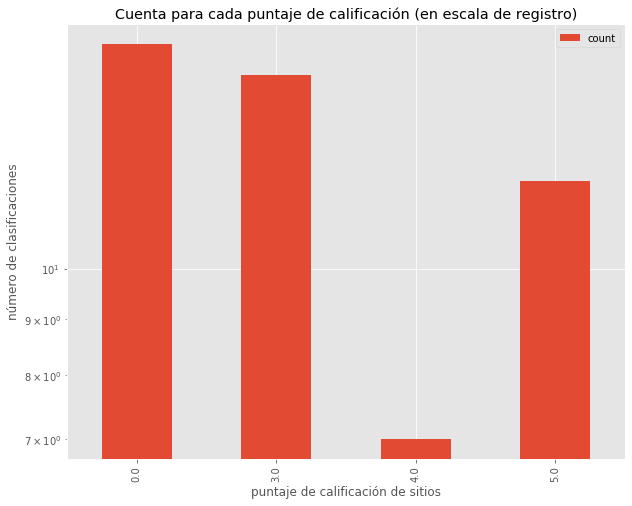

In [28]:
#GRAFICAR LAS CALIFICACION 
ax = df_ratings_cnt[['count']].reset_index().rename(columns={'index': 'rating score'}).plot(
    x='rating score',
    y='count',
    kind='bar',
    figsize=(10, 8),
    title='Cuenta para cada puntaje de calificación (en escala de registro)',
    logy=True,
    fontsize=10,
)
ax.set_xlabel("puntaje de calificación de sitios")
ax.set_ylabel("número de clasificaciones")

In [30]:
#RECUENTO DE USUARIOS CON EL NUMERO DE ITEM CALIFICADOS
df_sitios_cnt = pd.DataFrame(df_ratings.groupby('sitioID').size(), columns=['count'])
df_sitios_cnt.head()

,count
sitioID,
1,3
2,5
3,3
4,3
5,3


In [31]:
#CREAR LA MATRIZ APREGANDO UN 0 A LOS ITEM QUE NO TIENEN CALIFICACION ASIGNADA 
sitio_user_mat = df_ratings.pivot_table(index='sitioID', columns='userID', values='rating').fillna(0)
sitio_user_mat.head()

userID,1,2,3,4,5
sitioID,,,,,
1,0.0,3.0,3.0,3.0,0.0
2,4.0,5.0,3.0,5.0,5.0
3,3.0,0.0,0.0,5.0,5.0
4,4.0,3.5,0.0,0.0,0.0
5,0.0,0.0,3.0,3.0,4.0


In [32]:
# crear mapeador el nombre del sitio al índice
sitio_to_idx = {
    sitio: i for i, sitio in 
    enumerate(list(df_sitios.set_index('sitioID').loc[sitio_user_mat.index].nombre))
}
# transformar matriz en matriz escasa escasa
sitio_user_mat_sparse = csr_matrix(sitio_user_mat.values)

In [33]:
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
model_knn.fit(sitio_user_mat_sparse)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=20, p=2,
                 radius=1.0)

In [34]:
def fuzzy_matching(mapper, fav_sitio, verbose=True):
    match_tuple = []    
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_sitio.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))    
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('¡Uy! No se ha encontrado ninguna coincidencia.')
        return
    if verbose:
        print('Encontramos posibles coincidencias en nuestra base de datos:\n {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]

def make_recommendation(model_knn, data, mapper, fav_sitio, n_recommendations):    
    model_knn.fit(data)
    # obtener el índice de entrada del sitio
    print('Lugar:', fav_sitio)
    print('\n')
    idx = fuzzy_matching(mapper, fav_sitio, verbose=True)
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    # obtener la lista de idx sin procesar de las recomendaciones
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    reverse_mapper = {v: k for k, v in mapper.items()}    
    # imprimir recomendaciones
    print('RECOMENDACIONES PARA {}:'.format(fav_sitio))
    print('\n')
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1} - distancia {2}'.format(i+1, reverse_mapper[idx], dist))

In [35]:
def entrada(my_favorite):
    return make_recommendation(
        model_knn=model_knn,
        data=sitio_user_mat_sparse,
        fav_sitio=my_favorite,
        mapper=sitio_to_idx,
        n_recommendations=5)

In [36]:
entrada('JARDIN BOTANICO') 

Lugar: JARDIN BOTANICO


Encontramos posibles coincidencias en nuestra base de datos:
 ['JARDIN BOTANICO']

......

RECOMENDACIONES PARA JARDIN BOTANICO:


1: MANGLAR LA BOCA - distancia 0.4237288135593219
2: PARQUE VICENTE AMADOR FLOR - distancia 0.37400925982914
3: PARQUE MAMEY - distancia 0.2523980738829943
4: CERRO JABONCILLO - distancia 0.2185475087940636
5: PARQUE LAS VEGAS - distancia 0.19282875191889193


In [37]:
#CALCULAR EL PORCENTAJE DE ITEN QUE NO TIENE CALIFICACION 
# calcular el número total de entradas en la matriz de usuario de sitio
num_entries = sitio_user_mat.shape[0] * sitio_user_mat.shape[1]
# calcular el número total de entradas con valores cero
num_zeros = (sitio_user_mat==0).sum(axis=1).sum()
# calcular la relación entre el número de ceros y el número de entradas
ratio_zeros = num_zeros / num_entries
print('Falta aproximadamente el {:.2%} de las calificaciones en nuestros sitios.'.format(ratio_zeros))

Falta aproximadamente el 38.00% de las calificaciones en nuestros sitios.
